# 3D Flex: Custom Latent Trajectory

```{note}
[Read the tutorial](https://guide.cryosparc.com/processing-data/tutorials-and-case-studies/tutorial-3d-flexible-refinement) to learn more about 3D Flexible Refinement.
```

This example covers the following:

* Load particle latent coordinates from a 3D Flex Training job
* Plot the latent coordinates
* Interactively draw a trajectory through the latent space
* Output the trajectory as a new output in CryoSPARC

The resulting trajectory may be used as input to the 3D Flex Generator job to generate a volume series along the trajectory. In this way, you can visualize specific regions or pathways through the latent conformational distribution of the particle.

In [1]:
import numpy as n
from cryosparc.tools import CryoSPARC

cs = CryoSPARC(host="cryoem5", base_port=40000)
assert cs.test_connection()

Connection succeeded to CryoSPARC command_core at http://cryoem5:40002
Connection succeeded to CryoSPARC command_vis at http://cryoem5:40003


Load the particles dataset from the 3D Flex Training job.

In [9]:
import pandas as pd

project = cs.find_project("P251")
particles = project.find_job("J21").load_output("particles")

pd.DataFrame(particles.rows())

,components_mode_0/component,components_mode_0/value,components_mode_1/component,components_mode_1/value,uid
0,0,0.016000,1,0.314667,3070975014664207456
1,0,-0.122667,1,-0.293333,4618435520677801850
2,0,-0.496000,1,0.048000,5473205460946538064
3,0,0.357333,1,0.133333,16310523440862460071
4,0,0.698667,1,0.048000,13340786341065263892
...,...,...,...,...,...
83995,0,0.229333,1,0.314667,16055293458929423443
83996,0,-0.208000,1,0.784000,4138809144408497890
83997,0,0.069333,1,0.005333,12856011472364466207
83998,0,-0.176000,1,0.272000,14511870028664140377


Create an interative plot that responds to on-click events. 

Once the plot is drawn, click repeatedly on the plot along a trajectory you wish to sample in the latent space. The points along this trajectory will form the output of the notebook and be used in 3D Flex Generator.

<IPython.core.display.Javascript object>


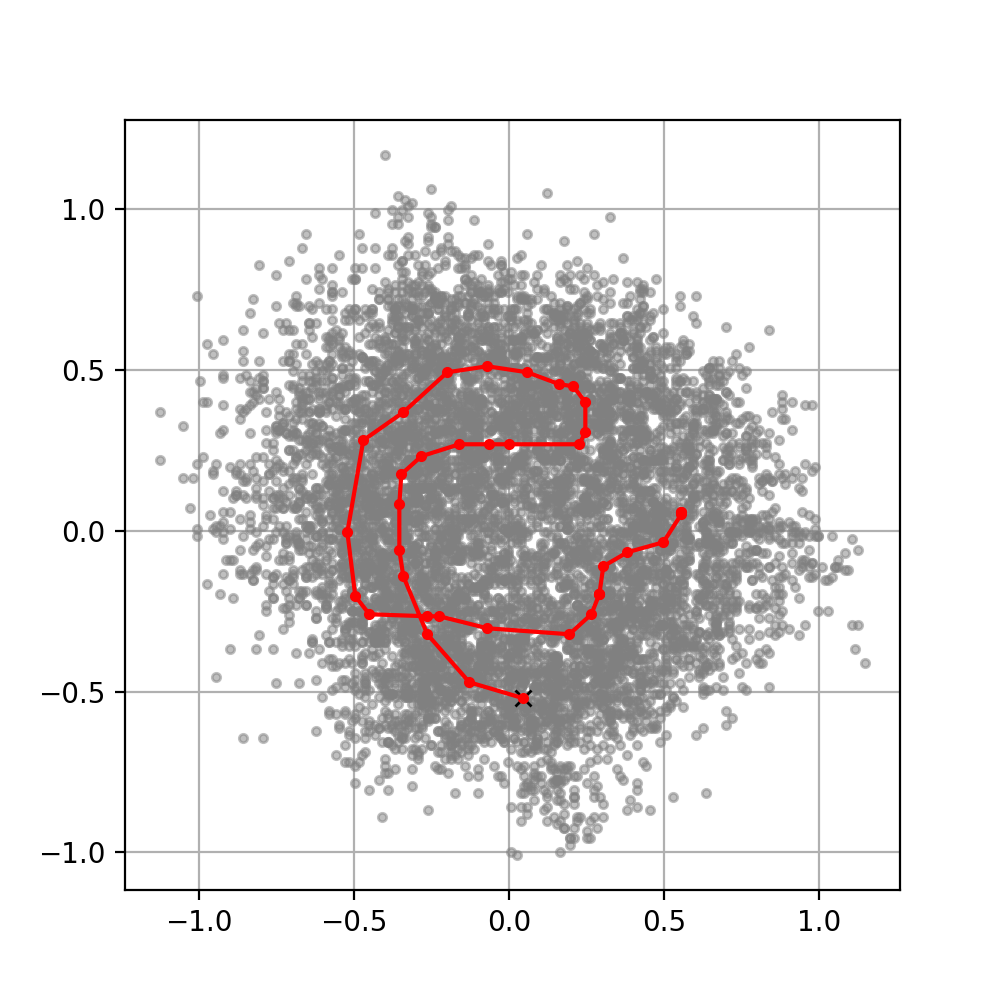

In [6]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(5, 5))


def do_plot():
    plt.plot(
        particles["components_mode_0/value"][::10],
        particles["components_mode_1/value"][::10],
        ".",
        alpha=0.5,
        color="gray",
    )
    plt.grid()


do_plot()

chain = True
pts = []


def onclick(event):
    fig.clf()
    do_plot()
    pts.append([event.xdata, event.ydata])
    apts = n.array(pts)
    if chain:
        plt.plot(apts[0, 0], apts[0, 1], "xk")
        plt.plot(apts[:, 0], apts[:, 1], ".-r")
    else:
        for k, i in enumerate(range(0, len(apts), 2)):
            plt.plot(apts[i, 0], apts[i, 1], "xk")
            plt.plot(apts[i : i + 2, 0], apts[i : i + 2, 1], ".-", label=str(k))
        plt.legend()


cid = plt.gcf().canvas.mpl_connect("button_press_event", onclick)

Print out the selected trajectory points.

In [7]:
latent_pts = n.array(pts)
for pt in latent_pts:
    print(f"{pt[0]:5.2f}, {pt[1]:5.2f}")

 0.05, -0.52
-0.13, -0.47
-0.26, -0.32
-0.34, -0.14
-0.35, -0.06
-0.35,  0.08
-0.35,  0.18
-0.28,  0.23
-0.16,  0.27
-0.06,  0.27
 0.00,  0.27
 0.23,  0.27
 0.25,  0.31
 0.25,  0.40
 0.21,  0.45
 0.16,  0.46
 0.06,  0.49
-0.07,  0.51
-0.20,  0.49
-0.34,  0.37
-0.47,  0.28
-0.52, -0.00
-0.50, -0.20
-0.45, -0.26
-0.26, -0.27
-0.23, -0.27
-0.07, -0.30
 0.19, -0.32
 0.26, -0.26
 0.29, -0.20
 0.29, -0.20
 0.29, -0.20
 0.30, -0.11
 0.38, -0.07
 0.50, -0.04
 0.56,  0.05
 0.56,  0.06
 0.56,  0.06


Set up an external job to save the custom latent components. Connect to the train job to ensure output fields get passed through.

In [11]:
job = project.create_external_job("W4", "Custom Latents")
job.connect("particles", "J21", "particles", slots=["components_mode_%d" % k for k in range(2)])

Add and allocate an output for the job to store the custom latent components.

In [22]:
latents_dset = job.add_output(
    type="particle",
    name="latents",
    slots=[{"prefix": "components_mode_%d" % k, "dtype": "components", "required": True} for k in range(2)],
    title="Latents",
    alloc=len(latent_pts),
)

Save the points into the allocated dataset.

In [23]:
for k in range(2):
    latents_dset["components_mode_%d/component" % k] = k
    latents_dset["components_mode_%d/value" % k] = latent_pts[:, k]

Save the output.

In [24]:
with job.run():
    job.save_output("latents", latents_dset)